## Imports

In [191]:
import os
import math

import pandas as pd
import geopandas as gpd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px # type: ignore

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.metrics import root_mean_squared_error

from datetime import date, timedelta, datetime
from tqdm.auto import tqdm

tqdm.pandas()

### Data prep

In [110]:
# Discrete sample data from sf_bay/cruiseall table
df_disc = pd.read_csv('Data Prep/cruiseall_20240711_CLEANED.csv')
df_disc = df_disc.dropna(subset=['calc_chlor']) # drops ~2%
df_disc.datetime = pd.to_datetime(df_disc.datetime)
df_disc['timestamp'] = df_disc.datetime.astype('int64').div(10**9)
display(df_disc.head())

# Peterson Flowthrough data
df_ft = pd.read_parquet('Merges/PETERSON_FINAL.parquet').reset_index(drop=True).drop(columns='index')
df_ft.datetime = pd.to_datetime(df_ft.datetime)
df_ft['timestamp'] = df_ft.datetime.astype('int64').div(10**9)
df_ft['water_temp'] = df_ft['water_temp'].combine_first(df_ft['bow_temp'])
df_ft.rename(columns={'chlor': 'm_chlor'}, inplace=True)
display(df_ft.head())

,datetime,date,time,station_id,dist,depth,disc_chlor,calc_chlor,chlrat,disc_oxy,calc_oxy,sat_oxy,dscrspm,calcspm,salinity,water_temp,timestamp
0,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,1.0,NaN,2.9,NaN,NaN,8.2,88.0,NaN,96.0,27.63,10.23,786090120.0
1,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,2.0,2.9,2.9,0.4,7.9,8.2,88.0,95.0,98.0,27.65,10.25,786090120.0
2,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,3.0,NaN,2.9,NaN,NaN,8.2,88.0,NaN,98.0,27.69,10.27,786090120.0
3,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,4.0,NaN,2.9,NaN,NaN,8.2,88.0,NaN,96.0,27.73,10.29,786090120.0
4,1994-11-29 06:22:00,1994-11-29,06:22:00,36.0,0.0,5.0,NaN,2.9,NaN,NaN,8.2,88.0,NaN,95.0,27.75,10.29,786090120.0


,datetime,lat,lon,depth,photic_depth,wind_spd,wind_dir,water_temp,air_temp,bow_temp,...,file,datetime_out,new_lat,new_lon,dist_m,p_id,d_from_start,d_from_station,station_id,timestamp
0,1994-11-29 05:25:21,37.55778,-122.2006,9.5,NaN,2.8,333.0,10.667,5.99,10.667,...,11290520.001,1994-11-29 05:25:21,37.559167,-122.199167,199.311480,1102.0,17.913932,929.348040,30.0,786086721.0
1,1994-11-29 05:25:27,37.55806,-122.2006,9.9,NaN,2.7,341.0,10.677,5.66,10.677,...,11290520.001,1994-11-29 05:25:27,37.559500,-122.199833,173.585801,1104.0,17.990672,998.896984,30.0,786086727.0
2,1994-11-29 05:25:33,37.55861,-122.2006,10.1,NaN,2.9,341.0,10.685,5.83,10.685,...,11290520.001,1994-11-29 05:25:33,37.559500,-122.199833,119.774825,1104.0,17.990672,998.896984,30.0,786086733.0
3,1994-11-29 05:25:39,37.55889,-122.2006,10.3,NaN,2.6,339.0,10.689,5.73,10.689,...,11290520.001,1994-11-29 05:25:39,37.559500,-122.199833,95.772003,1104.0,17.990672,998.896984,30.0,786086739.0
4,1994-11-29 05:25:45,37.55944,-122.2006,10.6,NaN,2.7,342.0,10.691,5.68,10.691,...,11290520.001,1994-11-29 05:25:45,37.559833,-122.200333,49.607724,1107.0,18.058674,1055.890438,30.0,786086745.0


### Dataset Metadata

In [93]:
ft_unique = df_ft.datetime.dt.date.nunique()
# More files than unique days because some runs are broken into multiple files (S to N, N to S)
ft_file = df_ft.file.nunique()
wq_unique = df_disc.datetime.dt.date.nunique()

df_disc_filter = df_disc.dropna(subset=['calc_chlor', 'disc_chlor']).datetime.dt.date.nunique()

print(f'Peterson runs (rough): {ft_unique}')
print(f'Runs by file: {ft_file}')
print(f'WQ measures by date: {wq_unique}')
print(f'WQ measures by date: {df_disc_filter} (with calcuated and discrete value)')

Peterson runs (rough): 524
Runs by file: 607
WQ measures by date: 611
WQ measures by date: 611 (with calcuated and discrete value)


---
### General Visualizations

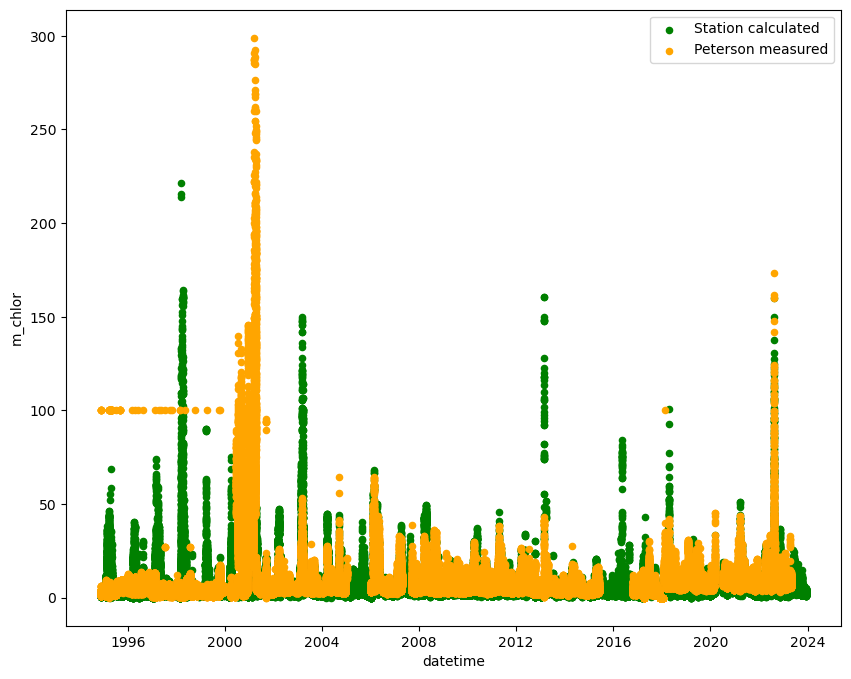

In [95]:
fig, ax = plt.subplots(figsize=(10, 8))
df_disc_gen = df_disc.copy()
df_ft_gen = df_ft.sample(n=len(df_disc))

df_ft_gen = df_ft_gen[df_ft_gen.m_chlor < 300]

df_disc_gen.plot(ax=ax, x='datetime', y='calc_chlor', c='green', kind='scatter', label='Station calculated')
df_ft_gen.plot(ax=ax, x='datetime', y='m_chlor', c='orange', kind='scatter', label='Peterson measured')
plt.show()

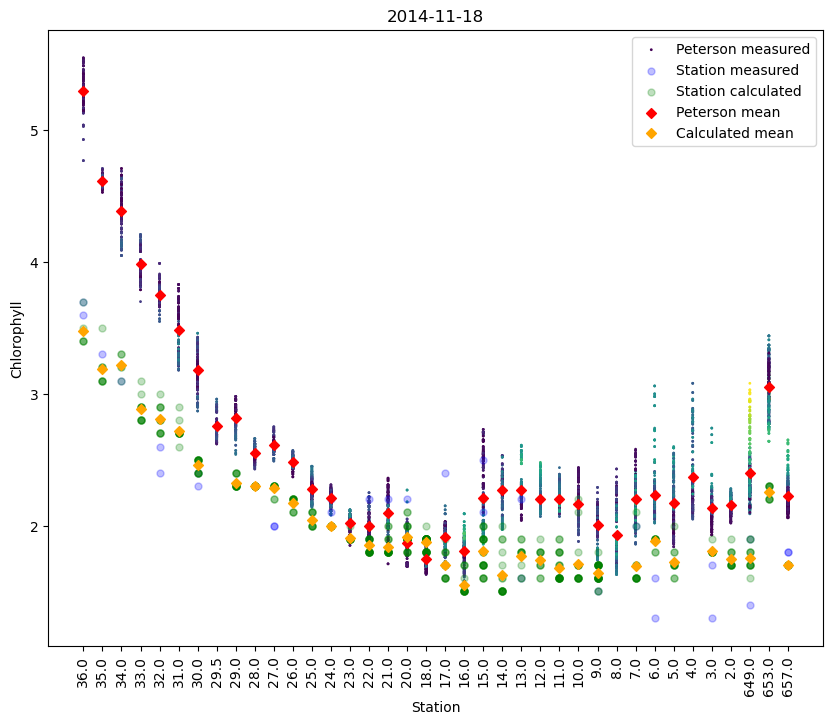

In [101]:
# date(year=2014, month=11, day=18) -- refline, closeish match
# date(year=1995, month=9, day=21) -- non linear, low match
# date(year=2006, month=8, day=2) -- high variation in calculated data

run_date = date(year=2014, month=11, day=18)

df_disc_gen = df_disc.copy()
df_ft_gen = df_ft.copy()

df_disc_gen = df_disc_gen[df_disc_gen.datetime.dt.date == run_date]
df_ft_gen = df_ft_gen[df_ft_gen.datetime.dt.date == run_date]
df_ft_sta_mean = pd.DataFrame(df_ft_gen.groupby('station_id')['m_chlor'].mean()).reset_index()
df_disc_calc_mean = pd.DataFrame(df_disc_gen.groupby('station_id')['calc_chlor'].mean()).reset_index()

# For dates before 1/1/2000
if run_date < date(year=2000, month=1, day=1):
    df_ft_gen = df_ft_gen[df_ft_gen.disc_chlor < 99]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_ft_gen['station_id'].astype(str), df_ft_gen['m_chlor'], c=df_ft_gen.d_from_station, label='Peterson measured', s=1)
ax.scatter(df_disc_gen['station_id'].astype(str), df_disc_gen['disc_chlor'], c='blue', label='Station measured', s=25, alpha=0.25)
ax.scatter(df_disc_gen['station_id'].astype(str), df_disc_gen['calc_chlor'], c='green', label='Station calculated', s=25, alpha=0.25)
ax.scatter(df_ft_sta_mean['station_id'].astype(str), df_ft_sta_mean['m_chlor'], c='red', marker='D', label='Peterson mean', s=25)
ax.scatter(df_disc_calc_mean['station_id'].astype(str), df_disc_calc_mean['calc_chlor'], c='orange', marker='D', label='Calculated mean', s=25)

plt.title(run_date)
plt.xlabel('Station')
plt.ylabel('Chlorophyll')
plt.xticks(rotation=90)
plt.legend()
plt.show()

---
## Single run regression (full run)

In [216]:
file = '14322dat.txt'

df_pet_single = df_ft.copy()
df_disc_single = df_disc.copy()

# Filtering Peterson data by file and extracting run date
df_pet_single = df_pet_single[df_pet_single.file == file].reset_index(drop=True)
date_ts = pd.to_datetime(df_pet_single.at[0, 'datetime'])
date_dt = date(year=date_ts.year, month=date_ts.month, day=date_ts.day)

# Temporally filter discrete data
df_disc_single = df_disc_single[df_disc_single.datetime.dt.date == date_dt]
df_disc_single_mean = pd.DataFrame(df_disc_single.groupby('station_id')['calc_chlor'].mean())

def single_regress(m_chlor: float, station_id: float, timestamp: int) -> float:
    try:
        calc_chlor = df_disc_single_mean.loc[station_id, 'calc_chlor']
        err = calc_chlor - m_chlor
        sq_err = (err ** 2)
        return err, sq_err
    except Exception as e:
        return None, None

df_pet_single[['error', 'sq_error']] = df_pet_single.progress_apply(lambda x: single_regress(x.m_chlor, x.station_id, x.timestamp), axis=1).apply(pd.Series)
#display(df_pet_single)

  0%|          | 0/8760 [00:00<?, ?it/s]

### RMSE/MAE

In [221]:
df_pet_single.dropna(subset=['error'], inplace=True)
rmse = round(math.sqrt(df_pet_single.sq_error.sum() / len(df_pet_single.sq_error)), 3)
mae = round(df_pet_single.error.abs().sum() / len(df_pet_single), 3)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.603
MAE: 0.495


### Single run regression visualization

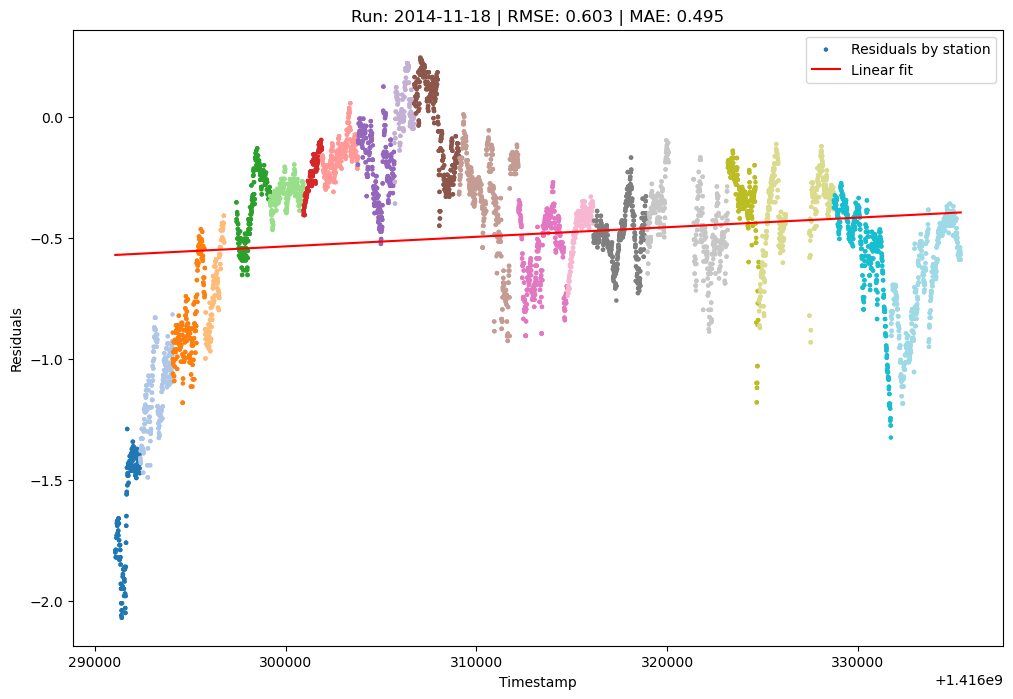

In [224]:
unique = df_pet_single.station_id.unique()
new_val = list(range(1, len(unique) + 1))
map_dict = dict(zip(unique, new_val))
df_pet_single.replace({'station_id': map_dict}, inplace=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x=df_pet_single.timestamp, y=df_pet_single.error, s=5, c=df_pet_single.station_id, cmap='tab20', label='Residuals by station')

m, b = np.polyfit(x=df_pet_single.timestamp, y=df_pet_single.error, deg=1)
ax.plot(df_pet_single.timestamp, (df_pet_single.timestamp * m + b), c='red', label='Linear fit')

plt.title(f'Run: {date_dt} | RMSE: {rmse} | MAE: {mae}')
plt.xlabel('Timestamp')
plt.ylabel('Residuals')
plt.legend()
plt.show()